In [5]:
import pandas as pd
import numpy as np 
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from PIL import Image
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import random
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 50)


def get_dates_between(start_date, end_date):
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d %H")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d %H")
    
    dates_list = []
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        dates_list.append((current_datetime.strftime("%Y-%m-%d"), current_datetime.strftime("%H")))
        current_datetime += timedelta(hours=1)

    return dates_list

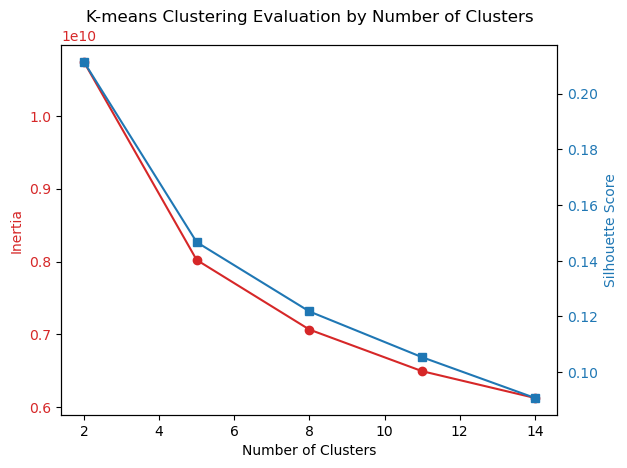

In [6]:
image_files = []

for date, hour in get_dates_between("2023-12-01 00", "2024-03-31 00"):
    for i in range(0, 59):
        minute = '{:02d}'.format(i)
        file_name = f"./ob/{date}/{hour}/{minute}.png"
        image_files.append(file_name)


# features와 image_shapes 리스트 초기화
features = []
image_shapes = []

# sampled_image_files에서 이미지 파일들을 가져와서 처리
sampled_image_files = random.sample(image_files, k=len(image_files)//100)
for image_file in sampled_image_files:
    try:
        image = Image.open(image_file)
        image = image.convert('RGB')  
        image = image.resize((40, 40))  
        image_shape = image.size  # 이미지의 width와 height 가져오기
        image_array = np.array(image)  # 이미지를 배열로 변환
        features.append(image_array.flatten())  # 이미지를 1차원 배열로 펼쳐서 특징 벡터에 추가
        image_shapes.append(image_shape)  # 이미지의 크기 정보 저장
    except:
        pass

# features를 numpy 배열로 변환
X = np.array(features)

# 클러스터 개수 범위 설정
cluster_range = range(2, 15, 3)

# K-means로 클러스터 개수에 따른 응집도 계산
inertia_values = []
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia = kmeans.inertia_  # inertia 값 계산
    inertia_values.append(inertia)
    
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, labels)  # 실루엣 스코어 계산
    silhouette_scores.append(silhouette_avg)

# 그래프로 나타내기
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(cluster_range, inertia_values, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)  
ax2.plot(cluster_range, silhouette_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('K-means Clustering Evaluation by Number of Clusters')
plt.show()


In [14]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

In [15]:
features = []
image_shapes = []  # 이미지의 크기를 저장할 리스트 추가
image_datetime = []

for image_file in image_files:
    try:
        image = Image.open(image_file)
        image_datetime.append(f"{image_file.split('/')[2]} {image_file.split('/')[3]}:{image_file.split('/')[4].split('.')[0]}")
    except:
        pass

df = pd.DataFrame(image_datetime, columns=['datetime'])
df['label'] = labels
df.to_csv("kmeans.csv")